# Работа с API VK

Для работы с vk api используется библиотека vk. Описание vk api: https://vk.com/dev/first_guide 

In [1]:
!pip install vk

  Created wheel for vk: filename=vk-2.0.2-cp36-none-any.whl size=8277 sha256=b82a8ae283b1e6e0b8a8be30147b11f3f1d913898961c18e522c0fa4028c88ac
  Stored in directory: /root/.cache/pip/wheels/4c/48/d1/09749ec47d9a30d166122773811f4ccb406f5234f2d84fd29d
Successfully built vk


In [2]:
import vk

In [9]:
login = 'log' # логин/номер телефона
password = 'pass' # пароль
vk_id = 'id' # id приложения vk

v = '5.103'

In [10]:
session = vk.AuthSession(app_id=vk_id, user_login=login, user_password=password) 
vkapi = vk.API(session, v=v)

### Задание 1

Получите список всех городов региона, в которых есть хотя бы одно учебное заведение и выведите их количество. Результат сохраните в формате csv.

In [13]:
import pandas as pd
import time

In [ ]:
vkapi.database.getUniversities(country_id=1, city_id=35, count=10000) # Великий Новгород

{'count': 15,
 'items': [{'id': 408, 'title': 'НовГУ'},
  {'id': 2068, 'title': 'СПбГУЭиФ (ФИНЭК) (НФ)'},
  {'id': 3072,
   'title': 'СИТиУ (филиал) МГУТУ им. К. Г. Разумовского (ПКУ) (бывш. СФ РГУИТП)'},
  {'id': 3911, 'title': 'СГА'},
  {'id': 5123, 'title': 'РГГУ (НФ)'},
  {'id': 5916, 'title': 'СПИУиП (НФ)'},
  {'id': 8168, 'title': 'СПбУ МВД РФ (НФ)'},
  {'id': 12326, 'title': 'РАНХиГС (НФ) (СЗАГС (НФ))'},
  {'id': 16639, 'title': 'СПбГУСЭ (НФ)'},
  {'id': 17485, 'title': 'ИНЖЭКОН (НФ)'},
  {'id': 22063, 'title': 'НИ ВШУ (НФ)'},
  {'id': 233201, 'title': 'РУК (НФ)'},
  {'id': 244846, 'title': 'СПбГУКИ (НФ)'},
  {'id': 1164593, 'title': 'НИППКРКС АПК'},
  {'id': 1187834, 'title': 'Филиал СПбГЭУ (ранее ФИНЭК, ИНЖЭКОН, СПбГУСЭ)'}]}

Получаем данные о городах

In [ ]:
reg_id = 1060458 # Новогородская область

offsets = 0
cities = {}
while True:
    data_city = vkapi.database.getCities(country_id=1, region_id=reg_id, offset = offsets, count = 1000)['items'] 
    if len(data_city) != 0:
        for i in data_city:
            cities[i['id']]=i['title']
        offsets += 1000
    else:
        break

Получаем данные об уч. заведениях. Если в городе есть хотя бы 1 уч.заведение – сохраняем

In [ ]:
city_uni = []
cnt_uni = []
for i in cities:
    time.sleep(0.15)
    uni_data = vkapi.database.getUniversities(country_id=1, city_id=i, count=10000)['count']
    if len(uni_data) >= 1:
        city_uni.append(cities[i])
        cnt_uni.append(len(uni_data))

Создаем датафрейм из полученных данных, сохраняем в csv и выводим

In [ ]:
df_uni = pd.DataFrame({'Город': city_uni, 'Кол-во учебных заведений': cnt_uni})
df_uni = df_uni.sort_values(['Кол-во учебных заведений', 'Город'], ascending=[False,True])
df_uni.to_csv('count_uni_in_city.csv')
df_uni

,Город,Кол-во учебных заведений
1,Великий Новгород,15
0,Боровичи,4
2,Старая Русса,2


# Работа с друзьями

##Задание 2.1

Построить по этим данным графики для себя и для ещё одного произвольно выбранного пользователя. Например, распределение друзей по полу, возрасту, университетам


In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

In [ ]:
def vk_friends(vkid):
    # получаем данные из вк
    data_vk = vkapi.friends.get (user_id=vkid, fields='sex, bdate, city, universities')['items']

    # обрабатываем полученные данные
    sex = []
    bdate = []
    city = []
    uni = []
    for i in data_vk:
        # пол
        if 'sex' in i:
            sex.append(i['sex'])
        else:
            sex.append('не указано')
        # дата рождения
        if 'bdate' in i:
            bdate.append(i['bdate'])
        else:
            bdate.append('не указано')
        # город
        if 'city' in i:
            city.append(i['city']['title'])
        else:
            city.append('не указано')
    # университет
    for i in data_vk:
        if 'universities' in i:
            s = set()
            for j in i['universities']:
                s.add(j['name'])
                for n in s:
                    uni.append(n.replace('\n', '').replace('\r', ''))
        else:
            uni.append('не указано')

    # подготавливаем данные для визуализации
    df = pd.DataFrame({'sex': sex, 'bdate': bdate, 'city': city})

    bd = df['bdate'].str.split('.',expand=True)
    bd.columns=['bday', 'bmonth', 'byear']
    df = pd.concat([df,bd], axis=1)
    df = df.drop('bdate', axis=1)
    df = df.fillna('не указано')

    df['sex'] = df['sex'].replace(1, 'жен')
    df['sex'] = df['sex'].replace(2, 'муж')
    df['bmonth'] = df['bmonth'].replace('1', 'янв')
    df['bmonth'] = df['bmonth'].replace('2', 'фев')
    df['bmonth'] = df['bmonth'].replace('3', 'мар')
    df['bmonth'] = df['bmonth'].replace('4', 'апр')
    df['bmonth'] = df['bmonth'].replace('5', 'май')
    df['bmonth'] = df['bmonth'].replace('6', 'июн')
    df['bmonth'] = df['bmonth'].replace('7', 'июл')
    df['bmonth'] = df['bmonth'].replace('8', 'авг')
    df['bmonth'] = df['bmonth'].replace('9', 'сен')
    df['bmonth'] = df['bmonth'].replace('10', 'окт')
    df['bmonth'] = df['bmonth'].replace('11', 'ноя')
    df['bmonth'] = df['bmonth'].replace('12', 'дек')

    uni_s = pd.Series(uni)
    uni_s = uni_s.replace('СПбГУ ИТМО', 'Университет ИТМО')
    uni_s = uni_s.replace('СПбНИУ ИТМО', 'Университет ИТМО')
    uni_s = uni_s.replace('НЮИ (ф) ТГУ', 'ТГУ')
    uni_s = uni_s.replace('КГУ им. Кирилла и Мефодия (бывш. КГИ) ', 'КГУ им. Кирилла и Мефодия')

    # визуализируем данные
    plt.style.use('bmh')
    plt.figure(figsize=(12, 7))
    plt.subplots_adjust(hspace=0.9)

    plt.subplot(2, 2, 1)
    plt_sex = df['sex'].value_counts()
    plt_sex.plot(kind='bar')
    plt.title("Распределение друзей пользователя по полу")
    plt.xlabel("Пол")
    plt.ylabel("Кол-во друзей")
    plt.tick_params(axis = 'x', labelrotation = 0)

    plt.subplot(2, 2, 2)
    plt_bmonth = df['bmonth'].value_counts()
    plt_bmonth.plot(kind='bar')
    plt.title("Распределение друзей пользователя\nпо месяцу дня рождения")
    plt.xlabel("Месяц дня рождения")
    plt.ylabel("Кол-во друзей")

    plt.subplot(2, 2, 3)
    plt_uni = uni_s.value_counts()
    plt_uni = plt_uni[plt_uni > 1]
    plt_uni.plot(kind='bar')
    plt.title("Распределение друзей пользователя\n по университетам (значение больше 1)")
    plt.xlabel("Университет")
    plt.ylabel("Кол-во друзей")

    plt.subplot(2, 2, 4)
    plt_city = df['city'].value_counts()
    plt_city = plt_city[plt_city > 1]
    plt_city.plot(kind='bar')
    plt.title("Распределение друзей пользователя\nпо городам (значение больше 1)")
    plt.xlabel("Город")
    plt.ylabel("Кол-во друзей")
    print('')
    return f'Результат анализа друзей пользователя id{vkid}' 

Анализ первого пользователя

'Результат анализа друзей пользователя id67254459'

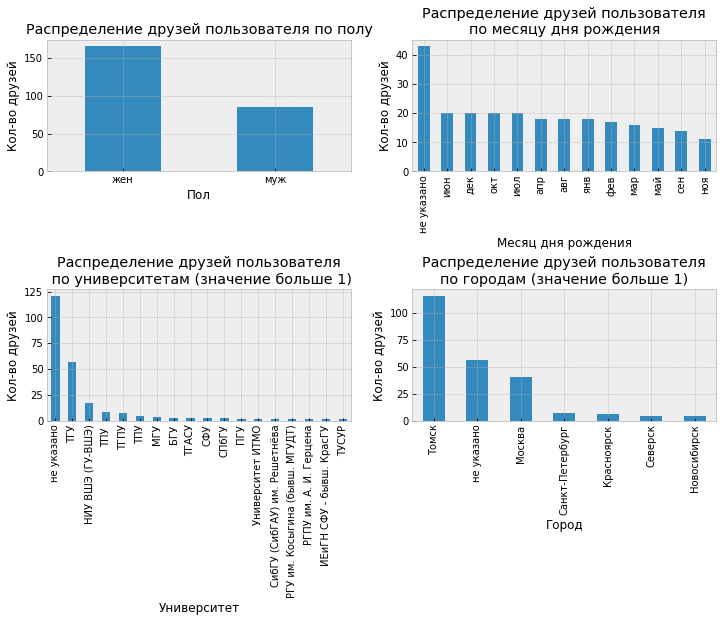

In [ ]:
vk_friends(67254459)

Анализ второго пользователя

'Результат анализа друзей пользователя id190372807'

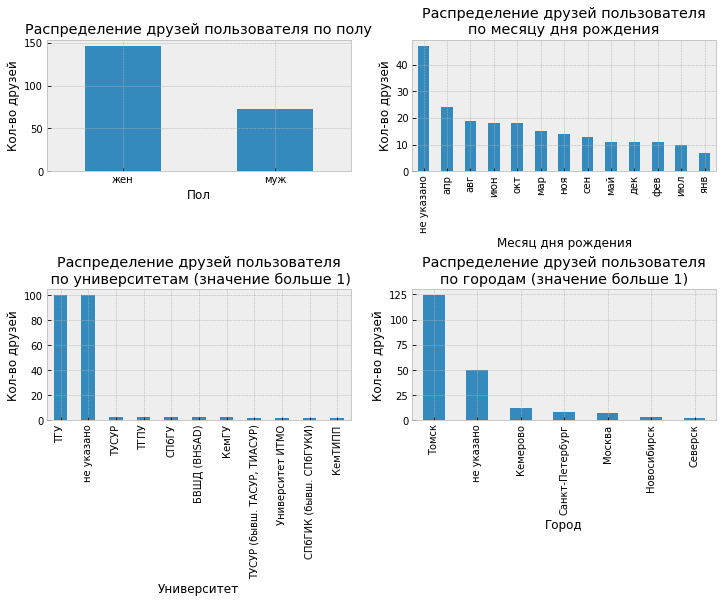

In [ ]:
vk_friends(190372807)

## Задание 2.2

Посчитаем fr-индекс: fr - количество друзей, у которых есть не менее fr - общих друзей

In [ ]:
def fr_index(vkid):
    try:
        # получаем id всех друзей пользователя
        id_friends = vkapi.friends.get(user_id=vkid)['items']
    
        # ищем общих друзей у пользователя с его друзьями
        common_fr = []
        for i in id_friends:
            try:
                time.sleep(0.15)
                fr = vkapi.friends.get(user_id=i)['items']
                for j in fr:
                    if j in id_friends:
                        common_fr.append(j)
            except: continue
      
        # вычисляем fr-индекс
        fri = len(id_friends)/len(common_fr)
        return f"fr-индекс пользователя id{vkid} равен {fri}"
    
    except: return f"У пользователя id{vkid} закрытая страница"

In [ ]:
fr_index(190372807)

'fr-индекс пользователя id190372807 равен 0.06500898741761534'

# Работа с группами (сообществами)

## Задание 3.1

Кто больше всех лайкает сообщения на стене сообщества?

In [ ]:
def like_in_group(id_group):
    if id_group[0] != '-':
        id_group = '-' + id_group
    # определяем кол-во записей на стене сообщества
    posts_id = []
    data_posts = vkapi.wall.get (owner_id=id_group, count = 1)['items']
    for i in data_posts:
        posts_id = [x for x in range(0, int(i['id'])+1)]

    # сохраняем id всех пользователей, которые оставили хотя бы 1 лайк под постами
    likes = []
    for i in posts_id:
        try:
            time.sleep(0.1)
            data_like = vkapi.likes.getList (type='post', owner_id=id_group, item_id=i)['items']
            for j in data_like:
                likes.append(j)
        except:
            continue

    # проводим расчеты и выводим график
    likes_s = pd.Series(likes)
    plt_like = likes_s.value_counts()
    plt_like = plt_like[:10]
    plt.style.use('bmh')
    plt.figure(figsize=(12, 7))

    plt.title(f"10 пользователей, которые оставили больше всего лайков за все время в сообществе\nvk.com/{'public' + id_group[1:]}")
    plt_like.plot(kind='bar')
    plt.xlabel("id пользователя")
    plt.ylabel("Кол-во лайков")
    print('')

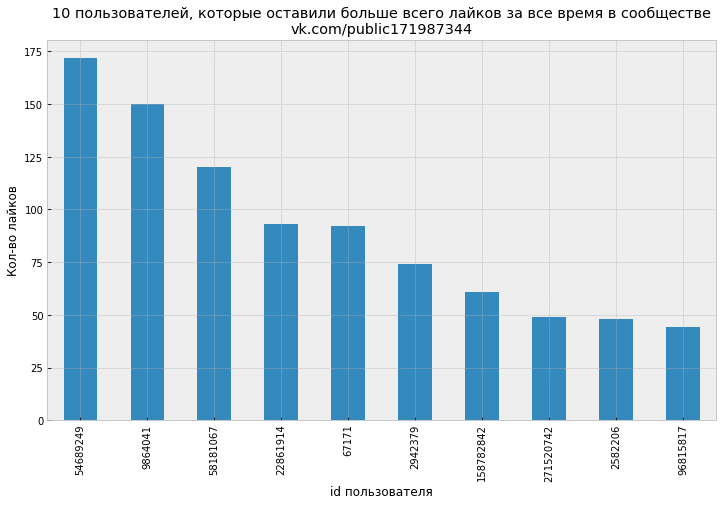

In [ ]:
like_in_group('171987344') # vk.com/dhcenter

## Задание 3.2

Какие самые популярные сообщества у членов сообщества? Для этого нужно в описании vk api найти метод для получения сообществ, на которые подписан пользователь

In [11]:
import collections

In [ ]:
# функция для разделения списка id групп на части по 500 в каждой, т.к. метод
# vkapi.groups.getById может за раз принять список только из 500 значений
def chunks(lst, chunk_size):
    return [lst[i:i+chunk_size] for i in range(0, len(lst), chunk_size)]

In [ ]:
def popular_public_members(domains):
    # получаем id участников сообщества
    members = vkapi.groups.getMembers(group_id=domains)['items']

    # получаем id групп и публичных страниц
    # try/except используется для обработки ошибок приватных страниц и
    # закрытой инфы о группах пользователя
    group_name = []
    public_id = []
    for i in members:
        try:
            subscid = vkapi.users.getSubscriptions(user_id=i, extended=0)['groups']['items']
            try:
                groupid = vkapi.groups.get(user_id=i, extended=0, count = 1000)['items']
                commonid = set(groupid)
                commonid.update(subscid)
                for i in list(commonid):
                    public_id.append(i)
            except:
                for i in subscid:
                    public_id.append(i)
        except: 
            continue

    # подсчитываем кол-во id
    dict_id = collections.Counter(public_id)
    ids = []
    cnt = []
    for i in dict_id.keys():
        ids.append(i)
    for i in dict_id.values():
        cnt.append(i)
    ids_l = chunks(ids, 500)

    # получаем названия сообществ по id 
    group_name = []
    for i in ids_l:
        time.sleep(0.3)
        data_group = vkapi.groups.getById(group_ids=i)
        for j in data_group:
            group_name.append(j['name'])

    # создаем датафейм
    df = pd.DataFrame({'ID': ids, 'Name': group_name, 'Count': cnt}).sort_values(by='Count', ascending=False)

    # возвращаем 10 популярных сообществ участников
    print(f'10 самых популярных сообществ у участников vk.com/{domains}')
    return df[1:11]

In [ ]:
popular_page_members('dhcenter') # vk.com/dhcenter

10 самых популярных сообществ у участников vk.com/dhcenter


,ID,Name,Count
379,63731512,Vandrouki | Путешествия почти бесплатно (RU),191
260,78423275,Arzamas,168
6,36507793,ПостНаука,145
35,16466790,Теории и практики,126
1196,76982440,«Медуза»,125
311,32943546,Журнал «Нож»,125
1050,168717779,Системный Блокъ,123
16,29534144,Лентач,116
1074,2499902,ITMO.STUDENTS,112
190,23303030,«Бумага»,111


## Задание 3.3

Получить ядро активности 1 для сообщества и сравнить со списком подписчиков.

Ядро активности 1 - это пользователи, которые совершили хотя бы одно  действие.

Для этого нужно научиться разбирать ответ и искать там авторов комментариев, а также пользователей, сделавших репосты.

vk [не дает полный доступ к репостам записей](https://vk.com/dev/wall.getReposts), поэтому для получения ядра активности они не учитывались

In [14]:
def core_activity(id_group):
    if id_group[0] != '-':
        id_group = '-' + id_group

    # определяем кол-во записей на стене сообщества
    posts_id = []
    data_posts = vkapi.wall.get (owner_id=id_group, count = 1)['items']
    for i in data_posts:
        posts_id = [x for x in range(0, int(i['id'])+1)]

    # получем id участников сообщества
    members = vkapi.groups.getMembers(group_id=id_group[1:])['items']

    # сохраняем id всех пользователей, которые оставили хотя бы 1 лайк под постами
    likes = []
    for i in posts_id:
        try:
            time.sleep(0.15)
            data_like = vkapi.likes.getList (type='post', owner_id=id_group, item_id=i)['items']
            for j in data_like:
                likes.append(j)
        except:
            continue

    # сохраняем id всех пользователей, которые оставили хотя бы 1 комментарий под постами
    comments = []
    for i in posts_id:
        try:
            time.sleep(0.15)
            data_like = vkapi.wall.getComments(owner_id=id_group, post_id = i, extended= 1, count = 100)['profiles']
            for j in data_like:
                comments.append(j['id'])
        except:
            continue
  
    # объединяем лайки и комменты в общий список активностей пользователей и
    # определяем является ли пользователь из списка activity участником сообщества
    activity = likes+comments
    member_or_not = []
    for i in activity:
        if i in members:
            member_or_not.append('да')
        else:
            member_or_not.append('нет')

    # выводим график
    plt_member_or_not = pd.Series(member_or_not).value_counts()
    plt.style.use('bmh')
    plt.figure(figsize=(12, 7))
    plt.title(f"Ядро активности пользователей 1 в сообществе vk.com/public{id_group[1:]}")
    plt_member_or_not.plot(kind='pie', subplots=True, autopct='%1.2f%%')
    plt.legend(title='Пользователь - участник сообщества', bbox_to_anchor=(1, 0.9))
    plt.ylabel("")
    print('')

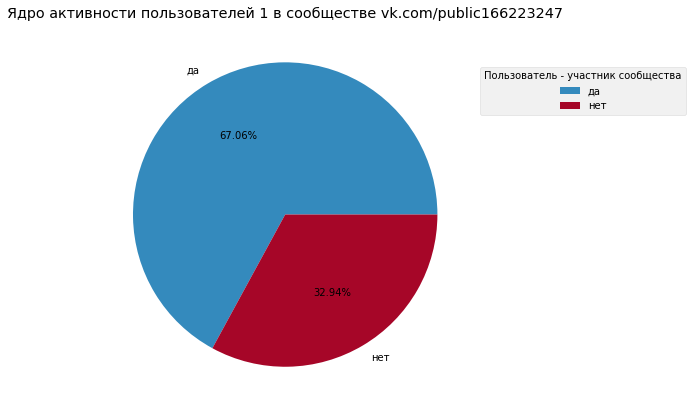

In [15]:
core_activity('166223247') # vk.com/cmbpodcast